### References

**Book:**
- Deep Learning with Python, Second Edition
  - Book by François Chollet
  - François Chollet is a French software engineer and artificial intelligence researcher currently working at Google. Chollet is the creator of the Keras deep-learning library, released in 2015, and a main contributor to the TensorFlow machine learning framework.


### Beyond text classification: Sequence-to-sequence learning

A sequence-to-sequence model takes a sequence as input (often a sentence or paragraph) and translates it into a different sequence. This is the task at the heart of many of the most successful applications of NLP:

- Machine translation—Convert a paragraph in a source language to its equivalent in a target language.
- Text summarization—Convert a long document to a shorter version that retains the most important information.
- Question answering—Convert an input question into its answer.
- Chatbots—Convert a dialogue prompt into a reply to this prompt, or convert the history of a conversation into the next reply in the conversation.
- Text generation—Convert a text prompt into a paragraph that completes the prompt.

The general template behind sequence-to-sequence models is described as follows During training,
- An encoder model turns the source sequence into an intermediate representation.
- A decoder is trained to predict the next token i in the target sequence by looking
at both previous tokens (0 to i - 1) and the encoded source sequence.

During inference, we don’t have access to the target sequence—we’re trying to predict it from scratch. We’ll have to generate it one token at a time:
1. We obtain the encoded source sequence from the encoder.
2. The decoder starts by looking at the encoded source sequence as well as an initial “seed” token (i.e. the string "[start]"), and uses them to predict the first real token in the sequence.
3. The predicted sequence so far is fed back into the decoder, which generates the next token, and so on, until it generates a stop token (such as the string "[end]").

Everything we’ve learned so far can be repurposed to build this new kind of model.

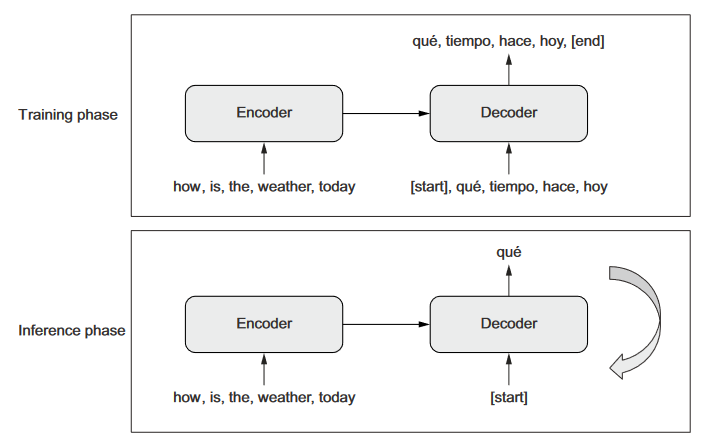

### A machine translation example

We’ll demonstrate sequence-to-sequence modeling on a machine translation task.

Machine translation is precisely what Transformer was developed for! We’ll start with a recurrent sequence model, and we’ll follow up with the full Transformer architecture.

We’ll be working with an English-to-Spanish translation dataset available at www.manythings.org/anki/

Let’s download it:

`!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip`

`!unzip -q spa-eng.zip`

The text file contains one example per line: an English sentence, followed by a tab character, followed by the corresponding Spanish sentence. 

Let’s parse this file.

In [2]:
# Data file
text_file = "spa-eng/spa.txt"

# Reading the file
# Split the data by \n (separate each line) and consider from start split (start line) to second last split (last line)
# Last split will be a blank character
with open(text_file, encoding='utf-8') as f:
    lines = f.read().split("\n")[:-1]

# Store text pair (english, spanish with start and end tags)
text_pairs = []

# Iterate over the lines in the file
for line in lines:
    # Each line contains an English phrase and its Spanish translation, tab-separated
    english, spanish = line.split("\t")

    # Append and prepend start and end tags to the target sequence (spanish)
    spanish = "[start] " + spanish + " [end]"
    
    # Appending english and corresponding modified spanish pair as tuple
    text_pairs.append((english, spanish))

In [3]:
import random

In [5]:
print(random.choice(text_pairs))

('Mary took out the eggs one by one.', '[start] Mary sacó los huevos uno por uno. [end]')


In [6]:
# Let’s shuffle them and split them into the usual training, validation, and test sets

# Shuffle
random.shuffle(text_pairs)

# Validation sample => 15% of all
num_val_samples = int(0.15 * len(text_pairs))

# Train sample => all - (2 * (Validation sample)) => (all - 30%) => 70% of all
num_train_samples = len(text_pairs) - 2 * num_val_samples

# Train pairs => start to num_train_samples => 70%
train_pairs = text_pairs[:num_train_samples]

# Validation pairs => num_train_samples to (num_train_samples + num_val_samples) => 15%
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]

# Test pairs => (num_train_samples + num_val_samples) till end => Rest 15%
test_pairs = text_pairs[num_train_samples + num_val_samples:]

Next, let’s prepare two separate TextVectorization layers: one for English and one for Spanish. 

We’re going to need to customize the way strings are preprocessed.

- We need to preserve the "[start]" and "[end]" tokens that we’ve inserted. By default, the characters '[' and ']' would be stripped, but we want to keep them around so we can tell apart the word “start” and the start token "[start]".

- Punctuation is different from language to language! In the Spanish TextVectorization layer, if we’re going to strip punctuation characters, we need to also strip the character ¿.

Note that for a non-toy translation model, we would treat punctuation characters as separate tokens rather than stripping them, since we would want to be able to generate correctly punctuated sentences. 

In our case, for simplicity, we’ll get rid of all punctuation.

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import string
import re

In [12]:
# Vectorizing the English and Spanish text pairs

# Want to strip "¿"
strip_chars = string.punctuation + "¿"

# Want to keep "[" and "]"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    # Lowercasing input string
    lowercase = tf.strings.lower(input_string)

    # Replace strip_chars with ""
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

In [13]:
# we’ll only look at the top 15,000 words in each language,
# we’ll restrict sentences to 20 words
vocab_size = 15000
sequence_length = 20

# Source vectorizer
source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    )

# Target vectorizer
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
    )

# Fetching the English and Spanish parts from train_pairs 
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]

# Fitting the texts into source and target vectorizers
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

Finally, we can turn our data into a tf.data pipeline. 

We want it to return a tuple (inputs, target) where inputs is a dict with two keys, “encoder_inputs” (the English
sentence) and “decoder_inputs” (the Spanish sentence), and target is the Spanish sentence offset by one step ahead.

In [14]:
# Preparing datasets for the translation task

batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        # Complete English
        "english": eng,
        # Spanish from [START] till before (excluding) the [END] token
        # The input Spanish sentence doesn’t include the last token to keep inputs and targets at the same length
        "spanish": spa[:, :-1],
        },
        # Spanish after (excluding) [START] token till [END] token
        # The target Spanish sentence is one step ahead. Both are still the same length (20 words)
        spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [15]:
# How a single batch looks like
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


We’ll start with a recurrent sequence-to-sequence model before moving on to a Transformer.

### Sequence-to-sequence learning with RNNs

Recurrent neural networks dominated sequence-to-sequence learning from 2015–2017 before being overtaken by Transformer. 

They were the basis for many real-world machine-translation systems, Google Translate circa 2017 was powered by a stack of seven large LSTM layers. 

It’s still worth learning about this approach today, as it provides an easy entry point to understanding sequence-to-sequence models.

The simplest, naive way to use RNNs to turn a sequence into another sequence is to keep the output of the RNN at each time step.

In [17]:
inputs = keras.Input(shape=(sequence_length,), dtype="int64")

x = layers.Embedding(input_dim=vocab_size, output_dim=128)(inputs)
x = layers.LSTM(32, return_sequences=True)(x)

outputs = layers.Dense(vocab_size, activation="softmax")(x)

model = keras.Model(inputs, outputs)

However, there are two major issues with this approach:

- The target sequence must always be the same length as the source sequence. In practice, this is rarely the case. Technically, this isn’t critical, as you could always pad either the source sequence or the target sequence to make their lengths match.

- Due to the step-by-step nature of RNNs, the model will only be looking at tokens 0…N in the source sequence in order to predict token N in the target sequence. This constraint makes this setup unsuitable for most tasks, and particularly translation. Consider translating “The weather is nice today” to French—that would be “Il fait beau aujourd’hui.” You’d need to be able to predict “Il” from just “The,” “Il fait” from just “The weather,” etc., which is simply impossible.

In a proper sequence-to-sequence setup, you would first use an RNN (the encoder) to turn the entire source sequence into a single vector (or set of vectors). 

This could be the last output of the RNN, or alternatively, its final internal state vectors. 

Then you would use this vector (or vectors) as the initial state of another RNN (the decoder), which would look at elements 0…N in the target sequence, and try to predict step N+1 in the target sequence.

Let’s implement this in Keras with GRU-based encoders and decoders. The choice of GRU rather than LSTM makes things a bit simpler, since GRU only has a single state vector, whereas LSTM has multiple.

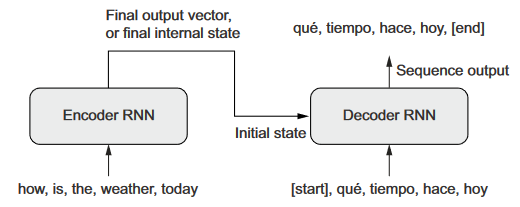

In [18]:
# GRU-based encoder

embed_dim = 256
latent_dim = 1024

# The English source sentence goes here
# Specifying the name of the input enables us to fit() the model with a dict of inputs
source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
# Our encoded source sentence is the last output of a bidirectional GRU
encoded_source = layers.Bidirectional(
    layers.GRU(latent_dim), merge_mode="sum")(x)

Next, let’s add the decoder—a simple GRU layer that takes as its initial state the encoded source sentence. 

On top of it, we add a Dense layer that produces for each output step a probability distribution over the Spanish vocabulary.

In [19]:
# GRU-based decoder and the end-to-end model

# Spanish target sentence goes here
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")

# Embedding with mask
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)

# The encoded source sentence serves as the initial state of the decoder GRU
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)

# Predicts the next token
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)

In [20]:
# End-to-end model: maps the source sentence and the target sentence to the target sentence one step in the future
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

During training, the decoder takes as input the entire target sequence, but thanks to the step-by-step nature of RNNs, it only looks at tokens 0…N in the input to predict token N in the output (which corresponds to the next token in the sequence, since
the output is intended to be offset by one step). 

This means we only use information from the past to predict the future, as we should; otherwise we’d be cheating, and our
model would not work at inference time.

In [21]:
# Training our recurrent sequence-to-sequence model

seq2seq_rnn.compile(optimizer="rmsprop",
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)


Epoch 1/15

  11/1302 [..............................] - ETA: 1:14:08 - loss: 9.3740 - accuracy: 0.1940

KeyboardInterrupt: 

We picked accuracy as a crude way to monitor validation-set performance during training. 

We get to 64% accuracy: on average, the model predicts the next word in the Spanish sentence correctly 64% of the time. 

However, in practice, next-token accuracy isn’t a great metric for machine translation models, in particular because it makes the
assumption that the correct target tokens from 0 to N are already known when predicting token N+1.

In reality, during inference, you’re generating the target sentence from scratch, and you can’t rely on previously generated tokens being 100% correct.

If you work on a real-world machine translation system, you will likely use “BLEU scores” to evaluate your models—a metric that looks at entire generated sequences and that seems to correlate well with human perception of translation quality.

At last, let’s use our model for inference. We’ll pick a few sentences in the test set and check how our model translates them. We’ll start from the seed token, "[start]", and feed it into the decoder model, together with the encoded English source sentence. 

We’ll retrieve a next-token prediction, and we’ll re-inject it into the decoder repeatedly, sampling one new target token at each iteration, until we get to "[end]" or reach the maximum sentence length.

In [22]:
import numpy as np

In [ ]:
# Translating new sentences with our RNN encoder and decoder

# Prepare a dict to convert token index predictions to string tokens
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))

max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    # Vectorizing input sentence
    tokenized_input_sentence = source_vectorization([input_sentence])
    
    # Seed token
    decoded_sentence = "[start]"


    for i in range(max_decoded_sentence_length):
        # Vectorizing target sentence
        # It is only [start] at this point
        tokenized_target_sentence = target_vectorization([decoded_sentence])

        # Predicting the next word in the target sentence
        # Probability distribution over all tokens
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        
        # Fetching the word with highest probability using the index and dictionary
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        
        # Joining the new word with the existing sentence to create the new decoded sentence 
        decoded_sentence += " " + sampled_token

        # If the current sampled token is [end] then we end the process 
        if sampled_token == "[end]":
            break

    # Finally returning the complete predicted sentence    
    return decoded_sentence

In [ ]:
# Testing


test_eng_texts = [pair[0] for pair in test_pairs]

for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

Note that this inference setup, while very simple, is rather inefficient, since we reprocess the entire source sentence and the entire generated target sentence every time we sample a new word. 

In a practical application, you’d factor the encoder and the decoder as two separate models, and your decoder would only run a single step at each token-sampling iteration, reusing its previous internal state.

The RNN approach to sequence-to-sequence learning has a few fundamental limitations:

- The source sequence representation has to be held entirely in the encoder state vector(s), which puts significant limitations on the size and complexity of the sentences you can translate. It’s a bit as if a human were translating a sentence
entirely from memory, without looking twice at the source sentence while producing the translation.

- RNNs have trouble dealing with very long sequences, since they tend to progressively forget about the past—by the time you’ve reached the 100th token in either sequence, little information remains about the start of the sequence. That means RNN-based models can’t hold onto long-term context, which can be essential for translating long documents.

These limitations are what has led the machine learning community to embrace the Transformer architecture for sequence-to-sequence problems.

### Sequence-to-sequence learning with Transformer

Sequence-to-sequence learning is the task where Transformer really shines. Neural attention enables Transformer models to successfully process sequences that are considerably longer and more complex than those RNNs can handle.

As a human translating English to Spanish, you’re not going to read the English sentence one word at a time, keep its meaning in memory, and then generate the Spanish sentence one word at a time. That may work for a five-word sentence, but it’s unlikely to work for an entire paragraph. Instead, you’ll probably want to go back and forth between the source sentence and your translation in progress, and pay attention to different words in the source as you’re writing down different parts of your translation.

That’s exactly what you can achieve with neural attention and Transformers. You’re already familiar with the Transformer encoder, which uses self-attention to produce context-aware representations of each token in an input sequence. In a
sequence-to-sequence Transformer, the Transformer encoder would naturally play the role of the encoder, which reads the source sequence and produces an encoded representation of it. Unlike our previous RNN encoder, though, the Transformer encoder keeps the encoded representation in a sequence format: it’s a sequence of context-aware embedding vectors.

The second half of the model is the Transformer decoder. Just like the RNN decoder, it reads tokens 0…N in the target sequence and tries to predict token N+1. Crucially, while doing this, it uses neural attention to identify which tokens in the encoded source sentence are most closely related to the target token it’s currently trying to predict—perhaps not unlike what a human translator would do. Recall the query-key-value model: in a Transformer decoder, the target sequence serves as an attention “query” that is used to to pay closer attention to different parts of the source sequence (the source sequence plays the roles of both keys and values).

#### THE TRANSFORMER DECODER

Look at the decoder internals: you’ll recognize that it looks very similar to the Transformer encoder, except that an extra attention block is inserted between the self-attention block applied to the target sequence and the dense layers of the exit block.

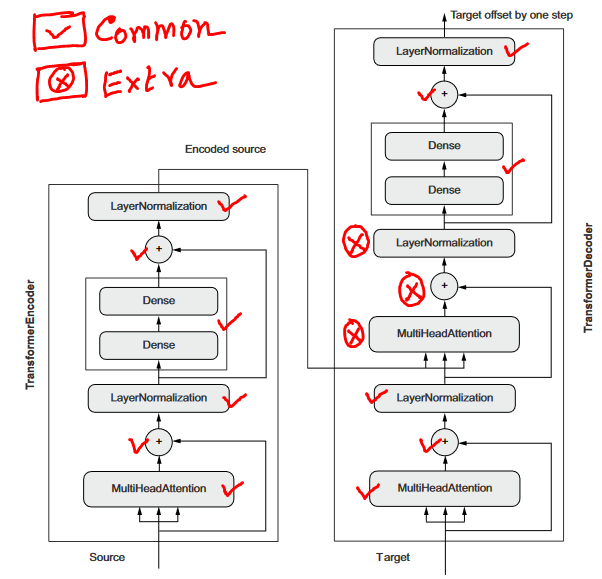

The call() method is almost a straightforward rendering of the connectivity diagram. But there’s an additional detail we need to take into account: causal padding. 

Causal padding is absolutely critical to successfully training a sequence-to-sequence Transformer. 

Unlike an RNN, which looks at its input one step at a time, and thus will only have access to steps 0...N to generate output step N (which is token N+1 in the target sequence), the TransformerDecoder is order-agnostic: it looks at the entire target sequence at once. 

If it were allowed to use its entire input, it would simply learn to copy input step N+1 to location N in the output. The
model would thus achieve perfect training accuracy, but of course, when running inference, it would be completely useless, since input steps beyond N aren’t available.

The fix is simple: we’ll mask the upper half of the pairwise attention matrix to prevent the model from paying any attention to information from the future—only information from tokens 0...N in the target sequence should be used when generating
target token N+1. 

To do this, we’ll add a get_causal_attention_mask(self, inputs) method to our TransformerDecoder to retrieve an attention mask that we can pass to our MultiHeadAttention layers.

In [34]:
# The TransformerDecoder

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        # Embedding dimension
        self.embed_dim = embed_dim
        # Dense layer dimension
        self.dense_dim = dense_dim
        # Number of attention heads
        self.num_heads = num_heads

        # Two self attention layer
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=embed_dim)
        
        # One dense projection layer
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"),
                                            layers.Dense(embed_dim),]
                                            )
        # Three normalization layer
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        # This attribute ensures that the layer will propagate its input mask to its 
        # If you pass a mask to a layer that doesn’t implement compute_mask() and that doesn’t expose this supports_masking attribute, that’s an error
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
            })
        return config
    
    # TransformerDecoder method that generates a causal mask
    def get_causal_attention_mask(self, inputs):
        # Data will come in batches (Batches of input)
        # Capturing the input shape (batch size X sequence length) 
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]

        # [0 1 2 3 4] to [[0], [1], [2], [3], [4]] with new axis
        i = tf.range(sequence_length)[:, tf.newaxis]
        # [0 1 2 3 4]
        j = tf.range(sequence_length)
        
        # Casual mask for attention
        mask = tf.cast(i >= j, dtype="int32")

        # Replicate it along the batch axis to get a matrix of shape (batch_size, sequence_length, sequence_length)
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat([
            tf.expand_dims(batch_size, -1),
            tf.constant([1, 1], dtype=tf.int32)
            ], 
            axis=0)
        return tf.tile(mask, mult)
    

    # The forward pass of the TransformerDecoder
    def call(self, inputs, encoder_outputs, mask=None):
        # Retrieve casual mask
        causal_mask = self.get_causal_attention_mask(inputs)
        
        # Prepare the input mask (that describes padding locations in the target sequence)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], 
                                   dtype="int32")
            # Merge the two masks together
            padding_mask = tf.minimum(padding_mask, causal_mask)
        
        # Output of first attention layer
        attention_output_1 = self.attention_1(query=inputs,
                                              value=inputs,
                                              key=inputs,
                                              # Pass the causal mask to the first attention layer, which performs self-attention over the target sequence
                                              attention_mask=causal_mask
                                              )
        
        # Output of the first normalization layer
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        
        # Output of the second attention layer
        attention_output_2 = self.attention_2(query=attention_output_1,
                                              value=encoder_outputs,
                                              key=encoder_outputs,
                                              # Pass the combined mask to the second attention layer, which relates the source  sequence to the target sequence
                                              attention_mask=padding_mask,
                                              )
        
        # Output of second normalization layer
        attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)

        # Output of dense projection layer
        proj_output = self.dense_proj(attention_output_2)

        # Output of final or third normalization layer
        return self.layernorm_3(attention_output_2 + proj_output)

#### PUTTING IT ALL TOGETHER: A TRANSFORMER FOR MACHINE TRANSLATION

The end-to-end Transformer is the model we’ll be training. It maps the source sequence and the target sequence to the target sequence one step in the future. 

It straightforwardly combines the pieces we’ve built so far: PositionalEmbedding layers, the TransformerEncoder, and the TransformerDecoder. 

Note that both the TransformerEncoder and the TransformerDecoder are shape-invariant, so you could be stacking many of them to create a more powerful encoder or decoder. 

In our example, we’ll stick to a single instance of each.

In [35]:
# Implementing positional embedding as a subclassed layer

class PositionalEmbedding(layers.Layer):
    # A downside of position embeddings is that the sequence length needs to be known in advance
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        # Prepare an Embedding layer for the token indices
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim,
            output_dim=output_dim)
        
        # Positonal embeddings
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, 
            output_dim=output_dim)
        
        # Sequence length, input and output dim
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
    
    def call(self, inputs):
        # Length of input
        length = tf.shape(inputs)[-1]
        
        # Defining positions as range
        positions = tf.range(start=0, limit=length, delta=1)
        
        # Token embeddings getting inputs
        embedded_tokens = self.token_embeddings(inputs)
        
        # Positional embedding getting positions
        embedded_positions = self.position_embeddings(positions)

        # Add both embedding vectors together
        return embedded_tokens + embedded_positions
    
    # Like the Embedding layer, this layer should be able to generate a mask so we can ignore padding 0s in the inputs
    # The compute_mask method will called automatically by the framework, and the mask will get propagated to the next layer
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    # Implement serialization so we can save the model
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            })
        return config

In [36]:
# Transformer encoder implemented as a subclassed Layer

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        # Extra kwargs to the parent class
        super().__init__(**kwargs)
        
        # Size of the input token vectors
        self.embed_dim = embed_dim
        
        # Size of the inner dense layer
        self.dense_dim = dense_dim
        
        # Number of attention heads
        self.num_heads = num_heads
        
        # Multihead attention layer
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim)

        # Dense projection layer
        self.dense_proj = keras.Sequential(
            [layers.Dense(
                dense_dim,
                activation="relu"),
                layers.Dense(embed_dim),
                ]
        )

        # Two normalization layers
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    # Computation goes in call
    def call(self, inputs, mask=None):
        # The mask that will be generated by the Embedding layer will be 2D
        # But the attention layer expects to be 3D or 4D, so we expand its rank
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        
        # Self attention layer
        attention_output = self.attention(
            inputs, 
            inputs,
            attention_mask=mask)
        
        # First normalization layer takes the input and output of the attention
        proj_input = self.layernorm_1(inputs + attention_output)
        
        # Dense projection layer takes output of the first normalization layer
        proj_output = self.dense_proj(proj_input)
        
        # Second normalization layer takes the output of the dense projection layer and output of the first normalization layer as residual connection
        return self.layernorm_2(proj_input + proj_output)
    
    # Implement serialization so we can save the model
    def get_config(self):
        config = super().get_config()
        config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
        })
        return config

In [37]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
# Encode the source sentence
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
# Encode the target sentence and combine it with the encoded source sentence
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
# Predict a word for each output position
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

In [38]:
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [40]:
transformer.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 english (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 spanish (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 positional_embedding (Posi  (None, None, 256)            3841280   ['english[0][0]']             
 tionalEmbedding)                                                                                 
                                                                                                  
 positional_embedding_1 (Po  (None, None, 256)            3841280   ['spanish[0][0]']       

In [ ]:
# Training the sequence-to-sequence Transformer

transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

transformer.fit(train_ds, epochs=30, validation_data=val_ds)

We’re now ready to train our model—we get to 67% accuracy, a good deal above the GRU-based model

In [ ]:
# Translating new sentences with our Transformer model

spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]

        predictions = transformer([tokenized_input_sentence, 
                                   tokenized_target_sentence])
        
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        
        if sampled_token == "[end]":
            break
    return decoded_sentence